In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.12/07


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Endcap_2GeV_add.4.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

def load_pgun_omtf():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Overlap_3GeV_add.4.root'
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

In [4]:
maxEvents = 4000000
#maxEvents = 500000
#maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4)
eta_bins = eta_bins[::-1]
pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)
#pt_bins = (-0.5, -0.3333, -0.2333, -0.1333, -0.07, 0.07, 0.1333, 0.2333, 0.3333, 0.5)
nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT)
superstrip_size = 32

assert(len(eta_bins) == 7+1)
assert(len(pt_bins) == 9+1)

from six.moves import range, zip, map, filter

from incrementalstats import IncrementalStats

def find_sector(phi):  # phi in radians
  dphi = delta_phi(phi, np.pi/12)  # sector 1 starts at 15 deg
  dphi = int(np.floor(dphi/(np.pi/3)))  # divide by 60 deg
  if dphi < 0:
    sector = 7 + dphi
  else:
    sector = 1 + dphi
  return sector

def find_endcap(eta):
  endcap = +1 if eta >= 0. else -1
  return endcap

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((np.abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def _find_bin_fast(x, bins):
  x = np.clip(x, bins[1], bins[2]-1e-7)
  binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
  return binx.astype(np.int32)

#def find_eta_bin_12(eta, bins=(12,1.2,2.4)):
#  return _find_bin_fast(np.abs(eta), bins)

def find_eta_bin_16(eta, bins=(16,0.8,2.4)):
  return _find_bin_fast(np.abs(eta), bins)

def find_pt_bin_100(pt, bins=(100,-0.5,0.5)):
  return _find_bin_fast(pt, bins)

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,1,3] = 5  # RE1/3
    lut[2,2,2] = 6  # RE2/2
    lut[2,2,3] = 6  # RE2/3
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    lut[0,1,1] = 12 # MB1
    lut[0,2,1] = 13 # MB2
    lut[0,3,1] = 14 # MB3
    lut[0,4,1] = 15 # MB4
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    return entry

find_emtf_layer = EMTFLayer()

# Decide EMTF hit zones
class EMTFZone(object):
  def __init__(self):
    lut = np.zeros((5,5,5,7,2), dtype=np.int32) - 99  # (type, station, ring) -> [zone] x [min_theta,max_theta]
    lut[1,1,4][0] = 4,17    # ME1/1a
    lut[1,1,4][1] = 16,25   # ME1/1a
    lut[1,1,4][2] = 24,36   # ME1/1a
    lut[1,1,4][3] = 34,43   # ME1/1a
    lut[1,1,4][4] = 41,53   # ME1/1a
    lut[1,1,1][0] = 4,17    # ME1/1b
    lut[1,1,1][1] = 16,25   # ME1/1b
    lut[1,1,1][2] = 24,36   # ME1/1b
    lut[1,1,1][3] = 34,43   # ME1/1b
    lut[1,1,1][4] = 41,53   # ME1/1b
    lut[1,1,2][4] = 46,54   # ME1/2
    lut[1,1,2][5] = 52,88   # ME1/2
    lut[1,1,2][6] = 78,88   # ME1/2
    lut[1,1,3][6] = 98,125  # ME1/3
    #
    lut[1,2,1][0] = 4,17    # ME2/1
    lut[1,2,1][1] = 16,25   # ME2/1
    lut[1,2,1][2] = 24,36   # ME2/1
    lut[1,2,1][3] = 34,43   # ME2/1
    lut[1,2,1][4] = 41,49   # ME2/1
    lut[1,2,2][5] = 53,90   # ME2/2
    lut[1,2,2][6] = 77,111  # ME2/2
    #
    lut[1,3,1][0] = 4,17    # ME3/1
    lut[1,3,1][1] = 16,25   # ME3/1
    lut[1,3,1][2] = 24,36   # ME3/1
    lut[1,3,1][3] = 34,40   # ME3/1
    lut[1,3,2][4] = 44,54   # ME3/2
    lut[1,3,2][5] = 52,90   # ME3/2
    lut[1,3,2][6] = 76,96   # ME3/2
    #
    lut[1,4,1][0] = 4,17    # ME4/1
    lut[1,4,1][1] = 16,25   # ME4/1
    lut[1,4,1][2] = 24,35   # ME4/1
    lut[1,4,2][3] = 38,43   # ME4/2
    lut[1,4,2][4] = 41,54   # ME4/2
    lut[1,4,2][5] = 52,90   # ME4/2
    #
    lut[2,1,2][5] = 52,84   # RE1/2
    lut[2,1,3][6] = 80,120  # RE1/3
    lut[2,2,2][5] = 56,88   # RE2/2
    lut[2,2,3][6] = 76,112  # RE2/3
    lut[2,3,1][0] = 4,17    # RE3/1
    lut[2,3,1][1] = 16,25   # RE3/1
    lut[2,3,1][2] = 24,36   # RE3/1
    lut[2,3,2][3] = 40,40   # RE3/2
    lut[2,3,2][4] = 40,52   # RE3/2
    lut[2,3,2][5] = 48,84   # RE3/2
    lut[2,3,3][3] = 40,40   # RE3/3
    lut[2,3,3][4] = 40,52   # RE3/3
    lut[2,3,3][5] = 48,84   # RE3/3
    lut[2,3,3][6] = 80,92   # RE3/3
    lut[2,4,1][0] = 4,17    # RE4/1
    lut[2,4,1][1] = 16,25   # RE4/1
    lut[2,4,1][2] = 24,31   # RE4/1
    lut[2,4,2][3] = 36,44   # RE4/2
    lut[2,4,2][4] = 44,52   # RE4/2
    lut[2,4,2][5] = 52,84   # RE4/2
    lut[2,4,3][3] = 36,44   # RE4/3
    lut[2,4,3][4] = 44,52   # RE4/3
    lut[2,4,3][5] = 52,84   # RE4/3
    #
    lut[3,1,1][1] = 16,26   # GE1/1
    lut[3,1,1][2] = 24,37   # GE1/1
    lut[3,1,1][3] = 35,45   # GE1/1
    lut[3,1,1][4] = 40,52   # GE1/1
    lut[3,2,1][0] = 7,19    # GE2/1
    lut[3,2,1][1] = 18,24   # GE2/1
    lut[3,2,1][2] = 23,36   # GE2/1
    lut[3,2,1][3] = 34,45   # GE2/1
    lut[3,2,1][4] = 40,46   # GE2/1
    #
    lut[4,1,1][0] = 4,17    # ME0
    lut[4,1,1][1] = 16,23   # ME0
    #
    lut[0,1,1][6] = 92,130  # MB1
    lut[0,2,1][6] = 108,138 # MB2
    lut[0,3,1][6] = 126,144 # MB3
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    answer = (entry[:,0] <= hit.emtf_theta) & (hit.emtf_theta <= entry[:,1])
    zones = np.nonzero(answer)
    if isinstance(zones, tuple):
      zones = zones[0]
    return zones

find_emtf_zones = EMTFZone()

# Decide EMTF hit phi (integer unit)
class EMTFPhi(object):
  def __call__(self, hit):
    emtf_phi = np.int32(hit.emtf_phi)
    if hit.type == kCSC:
      if hit.station == 1:
        if hit.ring == 1:
          bend_corr_lut = (-2.0832, 2.0497)  # ME1/1b (r,f)
        elif hit.ring == 4:
          bend_corr_lut = (-2.4640, 2.3886)  # ME1/1a (r,f)
        elif hit.ring == 2:
          bend_corr_lut = (-1.3774, 1.2447)  # ME1/2 (r,f)
        else:
          bend_corr_lut = (-0, 0)            # ME1/3 (r,f): no correction
        bend_corr = bend_corr_lut[int(hit.fr)] * hit.bend
        bend_corr = bend_corr if hit.endcap == 1 else (bend_corr * -1)
        bend_corr = int(round(bend_corr))
        emtf_phi = emtf_phi + bend_corr
      else:
        pass
    else:
      pass
    return emtf_phi

find_emtf_phi = EMTFPhi()

# Decide EMTF hit layer partner (to make pairs and calculate deflection angles)
class EMTFLayerPartner(object):
  def __init__(self):
    self.lut = np.array([2, 2, 0, 0, 0, 0, 2, 3, 4, 0, 2, 0, 0, 0, 0, 0], dtype=np.int32)
    assert(self.lut.shape[0] == nlayers)

  def __call__(self, emtf_layer, zone):
    partner = self.lut[emtf_layer]
    if zone >= 5:  # zones 5,6, use ME1/2
      if partner == 0:
        partner = 1
    return partner

find_emtf_layer_partner = EMTFLayerPartner()

# Decide EMTF road mode
def is_emtf_singlemu(mode):
  return mode in (11,13,14,15)

def is_emtf_doublemu(mode):
  return mode in (7,10,12) + (11,13,14,15)

def is_emtf_muopen(mode):
  return mode in (3,5,6,9) + (7,10,12) + (11,13,14,15)

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    elif hit.type == kDT:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  def check_emtf_phi(hit):
    if hit.type == kME0:
      return hit.emtf_phi > 0
    elif hit.type == kDT:
      return hit.emtf_phi > 0
    else:
      return True
  return check_bx(hit) and check_emtf_phi(hit)

In [5]:
# Main analysis

def analysis(verbose=1):
  tree = load_pgun()
  
  out_part, out_hits = [], []
  
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 3:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kDT and (hit.station == 1 or hit.station == 2):
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector (using csc-only 'mode')
    sector_mode_array = np.zeros((12,), dtype=np.int32)
    sector_hits_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_hits_array.shape):
      sector_hits_array[ind] = []
      
    legit_hits = filter(is_emtf_legit_hit, evt.hits)
    
    # Loop over hits
    for ihit, hit in enumerate(legit_hits):
      if hit.type == kDT:  # ignore for now
        continue
      
      assert(hit.emtf_phi < 5040)  # 84*60
      
      if hit.sim_tp1 == 0 and hit.sim_tp2 == 0:
        endsec = find_endsec(hit.endcap, hit.sector)
        if hit.type == kCSC:
          sector_mode_array[endsec] |= (1 << (4 - hit.station))
        elif hit.type == kME0:
          sector_mode_array[endsec] |= (1 << (4 - 1))
        elif hit.type == kDT:
          sector_mode_array[endsec] |= (1 << (4 - 1))
        sector_hits_array[endsec].append(hit)
    
    # Get the best sector
    best_sector = np.argmax(sector_mode_array)
    mode = sector_mode_array[best_sector]
    
    # Skip events without SingleMu modes
    if not is_emtf_singlemu(mode):
      continue
    
    # Get the hits
    sector_hits = sector_hits_array[best_sector]
    
    amap = {}  # zone -> hits
    
    # Loop over sector hits
    for ihit, hit in enumerate(sector_hits):
      hit.emtf_layer = find_emtf_layer(hit)
      assert(hit.emtf_layer != -99)
      
      hit.old_emtf_phi = hit.emtf_phi
      hit.emtf_phi = find_emtf_phi(hit)
      
      zones = find_emtf_zones(hit)
      for z in zones:
        amap.setdefault(np.asscalar(z), []).append(hit)
      continue  # end loop over sector_hits
    
    # Loop over map of zone -> hits
    ievt_part = []
    ievt_hits = []
    
    for k, v in amap.iteritems():
      zone = k
      hits = v
      
      mode = 0  # csc-only 'mode'
      for ihit, hit in enumerate(hits):
        if hit.type == kCSC:
          mode |= (1 << (4 - hit.station))
        elif hit.type == kME0:
          mode |= (1 << (4 - 1))
        elif hit.type == kDT:
          mode |= (1 << (4 - 1))
      
      if not is_emtf_singlemu(mode):
        continue
      
      # Output
      hits_array = np.zeros((60,3), dtype=np.int32) - 99  # output up to 60 hits
      for ihit, hit in enumerate(hits):
        if ihit == 60:
          break
        hits_array[ihit] = (hit.emtf_layer, hit.emtf_phi, hit.old_emtf_phi)
        
      ievt_part.append((part.invpt, part.eta, part.phi, zone, best_sector, mode))
      ievt_hits.append(hits_array)
      continue  # end loop over map of zone -> hits
    
    # Verbose
    if ievt < 20:
      ievt_nhits = [(x[:,0] != -99).sum() for x in ievt_hits]
      print ievt, part.pt, ievt_part, ievt_nhits
    
    # Output
    out_part += ievt_part
    out_hits += ievt_hits
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part, dtype=np.float32), np.asarray(out_hits, dtype=np.int32)

In [6]:
loaded = np.load('make_patterns_out.6.npz')
out_part = loaded['out_part']
out_hits = loaded['out_hits']

In [7]:
print out_part.shape, out_hits.shape

(3241925, 6) (3241925, 60, 3)


### Check bend corrections

### Find mean deflection angles

In [8]:
%%time

np.random.seed(2023)

_get_emtf_layer = lambda x: x[0]

_get_emtf_phi = lambda x: x[1]

patterns_match_me2 = np.empty((100, 16, nlayers), dtype=np.object)
patterns_match_me3 = np.empty((100, 16, nlayers), dtype=np.object)
for ind in np.ndindex(patterns_match_me2.shape):
  patterns_match_me2[ind] = []
  patterns_match_me3[ind] = []

patterns_pt_binning = np.empty(len(eta_bins)-1, dtype=np.object)
for ind in np.ndindex(patterns_pt_binning.shape):
  patterns_pt_binning[ind] = []

# Loop over part and hits
# - part is (part_invpt, part_eta, part_phi, zone, endsec, mode)
# - hits is a collection of (emtf_layer, emtf_phi, old_emtf_phi)

print("Processing events ...")

for part, hits in zip(out_part, out_hits):
  (part_invpt, part_eta, part_phi, zone, endsec, mode) = part
  zone, endsec = int(round(zone)), int(round(endsec))
  hits = hits[hits[:,0] != -99]
  
  ipt100 = find_pt_bin_100(part_invpt)
  ieta16 = find_eta_bin_16(part_eta)
  #ipt = find_pt_bin(part_invpt)
  #ieta = find_eta_bin(part_eta)
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    amap.setdefault(_get_emtf_layer(hit), []).append(hit)
    
  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer
    
  def _find_dphi():
    dphi = np.float32(0)
    dphi += (hit_phi1 - hit_phi2)
    dphi /= (np.sinh(1.8587) / np.sinh(np.abs(part_eta)))
    dphi = np.round(dphi)
    return dphi.astype(np.int32)
  
  # Make pair of hits
  for k, v in amap.iteritems():
    emtf_layer = k
    hit1 = v
    hit_phi1 = _get_emtf_phi(hit1)
    
    # w.r.t ME2
    emtf_layer_me2 = 2
    hit2 = amap.get(emtf_layer_me2, None)
    if hit2 is not None:
      hit_phi2 = _get_emtf_phi(hit2)
      dphi = _find_dphi()
      patterns_match_me2[ipt100, ieta16, emtf_layer].append(dphi)
    
    # w.r.t ME3
    emtf_layer_me3 = 3
    hit2 = amap.get(emtf_layer_me3, None)
    if hit2 is not None:
      hit_phi2 = _get_emtf_phi(hit2)
      dphi = _find_dphi()
      patterns_match_me3[ipt100, ieta16, emtf_layer].append(dphi)
      
  # Check pt
  if zone == 6:
    if np.abs(1.0/part_invpt) > 4:
      patterns_pt_binning[zone].append(part_invpt)
  elif zone == 5:
    if np.abs(1.0/part_invpt) > 2.5:
      patterns_pt_binning[zone].append(part_invpt)
  else:
    patterns_pt_binning[zone].append(part_invpt)
  continue  # end loop over part and hits

Processing events ...
CPU times: user 28min 16s, sys: 25.2 s, total: 28min 41s
Wall time: 27min 55s


In [9]:
patterns_pt_binning_1 = np.zeros((len(eta_bins)-1, len(pt_bins)), dtype=np.float32)

p = (20-3.0,40,60,80,100-1.0)
assert(len(pt_bins) == 10)
assert(len(p) == 5)

x_bigzone0 = patterns_pt_binning[0] + patterns_pt_binning[1]
x_bigzone1 = patterns_pt_binning[2] + patterns_pt_binning[3] + patterns_pt_binning[4]
x_bigzone2 = patterns_pt_binning[5]
#x_bigzone3 = patterns_pt_binning[6]

x_bigzone0 = np.percentile(np.abs(x_bigzone0), p, overwrite_input=True)
x_bigzone1 = np.percentile(np.abs(x_bigzone1), p, overwrite_input=True)
x_bigzone2 = np.percentile(np.abs(x_bigzone2), p, overwrite_input=True)
#x_bigzone3 = np.percentile(np.abs(x_bigzone3), p, overwrite_input=True)

x_bigzone0 = np.hstack((-x_bigzone0[::-1], x_bigzone0))
x_bigzone1 = np.hstack((-x_bigzone1[::-1], x_bigzone1))
x_bigzone2 = np.hstack((-x_bigzone2[::-1], x_bigzone2))
#x_bigzone3 = np.hstack((-x_bigzone3[::-1], x_bigzone3))

patterns_pt_binning_1[0] = x_bigzone0
patterns_pt_binning_1[1] = x_bigzone0
patterns_pt_binning_1[2] = x_bigzone1
patterns_pt_binning_1[3] = x_bigzone1
patterns_pt_binning_1[4] = x_bigzone1
patterns_pt_binning_1[5] = x_bigzone2
#patterns_pt_binning_1[6] = x_bigzone3
print patterns_pt_binning_1

[[-0.49398187 -0.3903561  -0.29016334 -0.1923733  -0.08155756  0.08155756
   0.1923733   0.29016334  0.3903561   0.49398187]
 [-0.49398187 -0.3903561  -0.29016334 -0.1923733  -0.08155756  0.08155756
   0.1923733   0.29016334  0.3903561   0.49398187]
 [-0.47454104 -0.33101726 -0.23888423 -0.1566467  -0.06647749  0.06647749
   0.1566467   0.23888423  0.33101726  0.47454104]
 [-0.47454104 -0.33101726 -0.23888423 -0.1566467  -0.06647749  0.06647749
   0.1566467   0.23888423  0.33101726  0.47454104]
 [-0.47454104 -0.33101726 -0.23888423 -0.1566467  -0.06647749  0.06647749
   0.1566467   0.23888423  0.33101726  0.47454104]
 [-0.37961075 -0.26519662 -0.19233514 -0.12674046 -0.05346236  0.05346236
   0.12674046  0.19233514  0.26519662  0.37961075]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]


In [10]:
patterns_match_me2_1 = np.zeros(patterns_match_me2.shape, dtype=np.int32)
patterns_match_me3_1 = np.zeros(patterns_match_me3.shape, dtype=np.int32)
for ind in np.ndindex(patterns_match_me2.shape):
  # Fix issues due to gap between ring 1 & ring 2 at eta=1.6 (ieta16=8)
  ipt100, ieta16, emtf_layer = ind
  x = patterns_match_me2[ind]
  if ieta16 == 7:
    x = list(x) + patterns_match_me2[ipt100, 8, emtf_layer]
  elif ieta16 == 8:
    x = list(x) + patterns_match_me2[ipt100, 7, emtf_layer]
  #
  if len(x) > 100:
    patterns_match_me2_1[ind] = np.percentile(x, [50], overwrite_input=True)
    
for ind in np.ndindex(patterns_match_me3.shape):
  # Fix issues due to gap between ring 1 & ring 2 at eta=1.7 (ieta16=9)
  ipt100, ieta16, emtf_layer = ind
  x = patterns_match_me3[ind]
  if ieta16 == 8:
    x = list(x) + patterns_match_me3[ipt100, 9, emtf_layer]
  elif ieta16 == 9:
    x = list(x) + patterns_match_me3[ipt100, 8, emtf_layer]
  #
  if len(x) > 100: 
    patterns_match_me3_1[ind] = np.percentile(x, [50], overwrite_input=True)

In [11]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# https://matplotlib.org/users/dflt_style_changes.html#colors-in-default-property-cycle
# https://github.com/vega/vega/wiki/Scales#scale-range-literals
category10_palette  = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')
category20_palette  = ('#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5')
category10a_palette = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5')

DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Liberation Sans (u'/usr/share/fonts/liberation/LiberationSans-Regular.ttf') with score of 4.050000
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


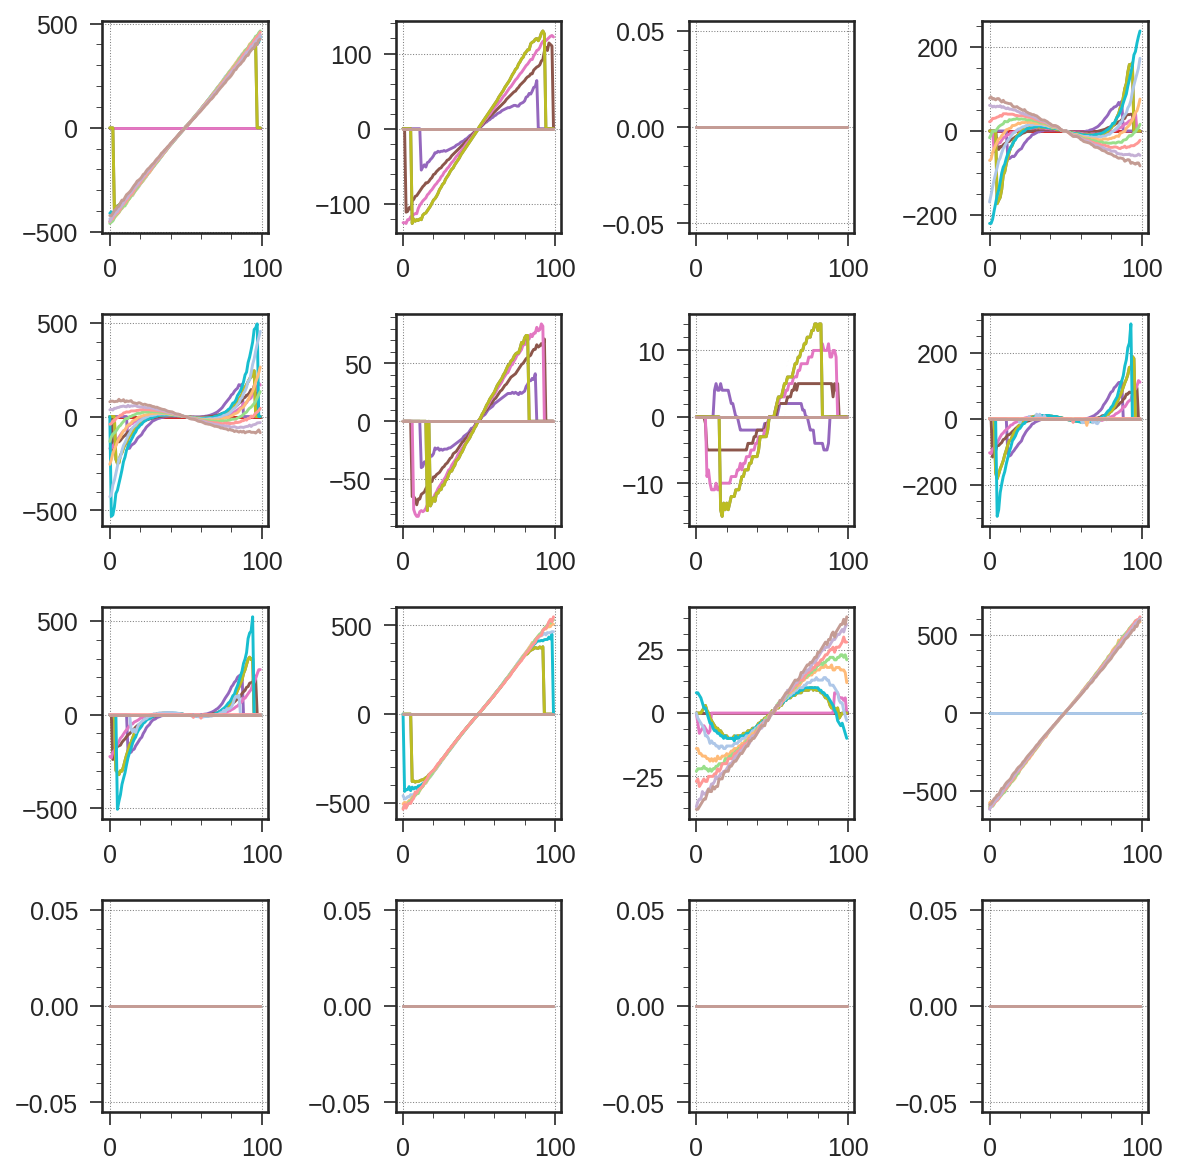

In [12]:
# w.r.t ME2
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(8,8), tight_layout=True)

for i in xrange(nlayers):
  for j in xrange(16):  # ieta16
    yy = patterns_match_me2_1[:,j,i]
    axs[i/4,i%4].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
plt.show()

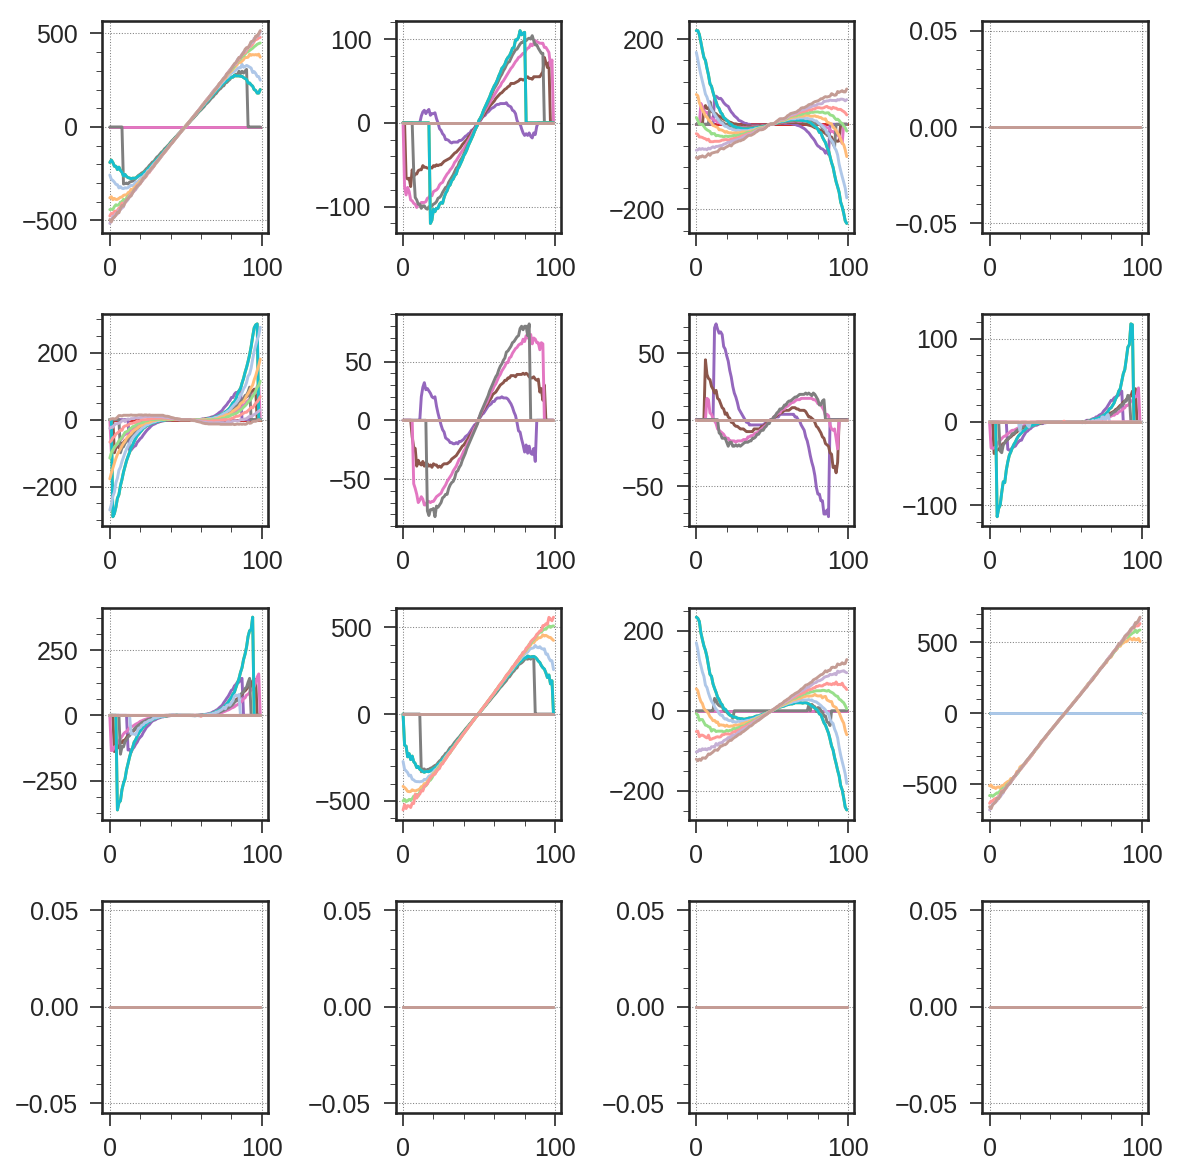

In [13]:
# w.r.t ME3
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(8,8), tight_layout=True)

for i in xrange(nlayers):
  for j in xrange(16):  # ieta16
    yy = patterns_match_me3_1[:,j,i]
    axs[i/4,i%4].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
plt.show()

In [14]:
# Linear regression
from sklearn.linear_model import LinearRegression

# Smoothing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
#kernel = C(10000.0, (1e-2, 1e7)) * RBF(1.0, (1e-2, 1e2)) + W(1.0, (1e-5, 1e5))
#gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=10)

patterns_match_me2_2 = np.zeros(patterns_match_me2_1.shape, dtype=np.int32)
patterns_match_me3_2 = np.zeros(patterns_match_me3_1.shape, dtype=np.int32)

In [15]:
# ME0 w.r.t ME2, ME3

emtf_layer_me1 = 11

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(12,16):  # ME0, valid for eta >= 2.0
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 0.85+j*0.1
    eta_s = 0.85+(15)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 1
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 50
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 0.8+j*0.1, 0.8+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,11,emtf_layer_me1] = patterns_match_me2_2[:,12,emtf_layer_me1]
patterns_match_me3_2[:,11,emtf_layer_me1] = patterns_match_me3_2[:,12,emtf_layer_me1]

0,(2.0,2.1) 14 (852606.6981924652, 0.7082987828834082)
0,(2.1,2.2) 10 (1043063.705831362, 0.792599072440989)
0,(2.2,2.3) 6 (1092286.0200646967, 0.8364506516645834)
0,(2.3,2.4) 1 (615544.4119061251, 0.7285722592862586)
1,(2.0,2.1) 14 (2781262.434659811, 1.5)
1,(2.1,2.2) 10 (3000000.0000000023, 1.3489958753868385)
1,(2.2,2.3) 6 (1902210.9539020045, 1.0319183064487933)
1,(2.3,2.4) 1 (598456.6972885204, 0.6738891351337541)


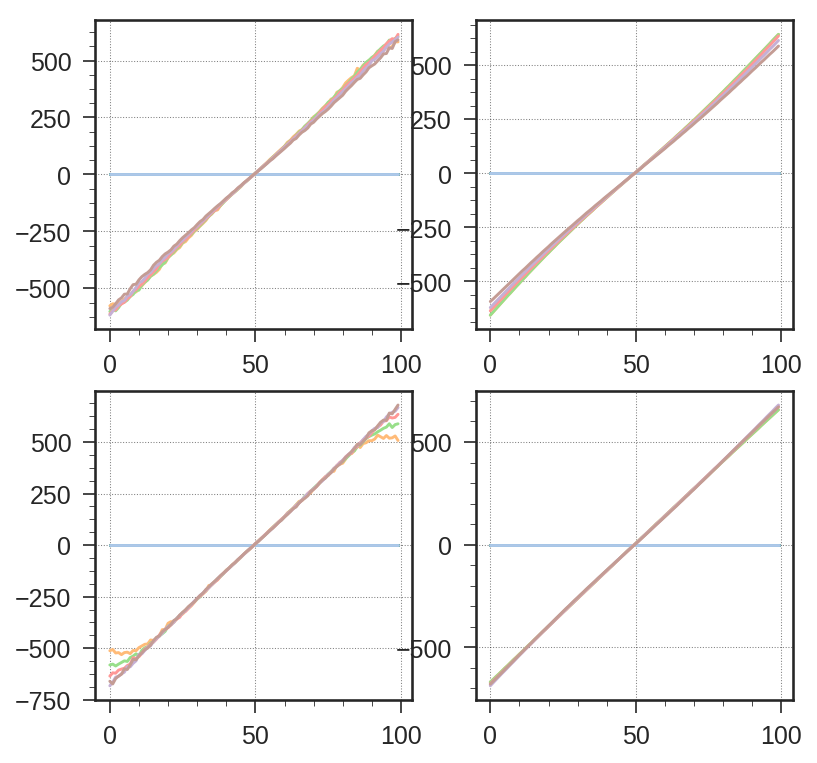

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(16):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [17]:
# ME1/1 w.r.t ME2, ME3

emtf_layer_me1 = 0

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(7,16):  # ME1/1, valid for eta >= 1.5
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 0.85+j*0.1
    eta_s = 0.85+(15)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 3
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 50
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 0.8+j*0.1, 0.8+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,7,emtf_layer_me1] = patterns_match_me2_2[:,8,emtf_layer_me1]
patterns_match_me3_2[:,7,emtf_layer_me1] = patterns_match_me3_2[:,8,emtf_layer_me1]

0,(1.5,1.6) 30 (583947.3878150296, 1.5)
0,(1.6,1.7) 28 (595353.0856565695, 1.5)
0,(1.7,1.8) 25 (669200.0793129886, 1.5)
0,(1.8,1.9) 23 (295263.59212834877, 0.5566940259163248)
0,(1.9,2.0) 20 (351950.5365321596, 0.6209652575378155)
0,(2.0,2.1) 16 (447100.1187169954, 0.6919549301113617)
0,(2.1,2.2) 12 (546966.3737448447, 0.7780518724725951)
0,(2.2,2.3) 8 (707083.3640693746, 0.874688971078707)
0,(2.3,2.4) 3 (715944.9487152174, 0.9334210659318879)
1,(1.5,1.6) 30 (607207.466674546, 1.5)
1,(1.6,1.7) 28 (674038.4066305392, 1.5)
1,(1.7,1.8) 25 (658505.6932529043, 1.5)
1,(1.8,1.9) 23 (709193.9226901373, 1.5)
1,(1.9,2.0) 20 (726282.0946383772, 1.5)
1,(2.0,2.1) 16 (859176.0465786874, 1.5)
1,(2.1,2.2) 12 (1029223.2857850215, 1.5)
1,(2.2,2.3) 8 (1450861.9928265335, 1.1328245110757063)
1,(2.3,2.4) 3 (1238692.4621546832, 1.0802675669119044)


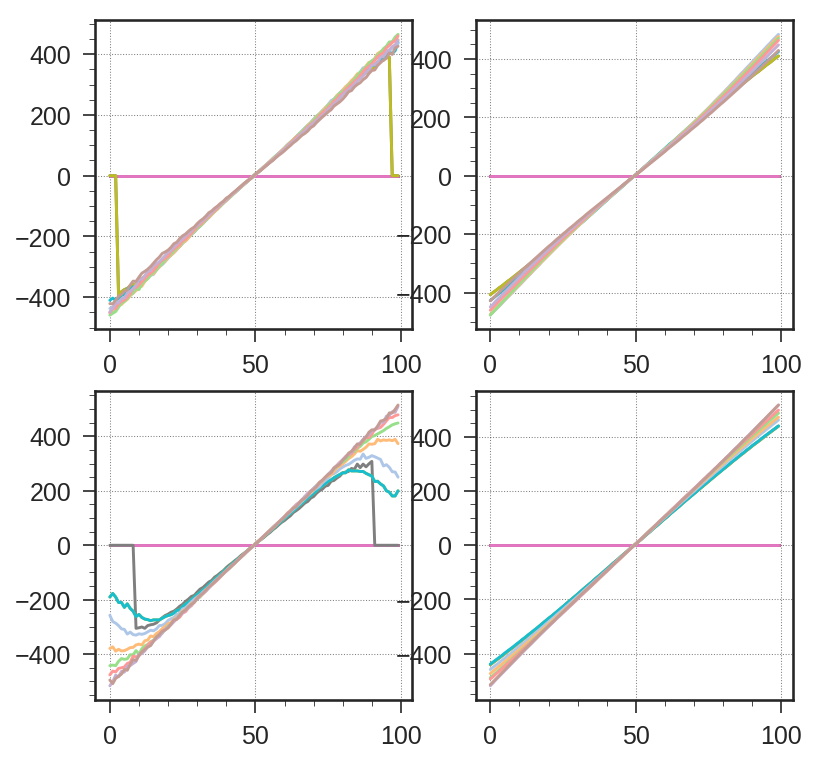

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(16):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [19]:
# GE1/1 w.r.t ME2, ME3

emtf_layer_me1 = 9

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(7,14):  # GE1/1, valid for 1.5 <= eta <= 2.2
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 0.85+j*0.1
    eta_s = 0.85+(15)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 3
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 50
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 0.8+j*0.1, 0.8+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,7,emtf_layer_me1] = patterns_match_me2_2[:,8,emtf_layer_me1]
patterns_match_me3_2[:,7,emtf_layer_me1] = patterns_match_me3_2[:,8,emtf_layer_me1]
patterns_match_me2_2[:,13,emtf_layer_me1] = patterns_match_me2_2[:,12,emtf_layer_me1]
patterns_match_me3_2[:,13,emtf_layer_me1] = patterns_match_me3_2[:,12,emtf_layer_me1]

0,(1.5,1.6) 30 (856726.9052300985, 1.5)
0,(1.6,1.7) 28 (240648.46519748642, 0.4406800284048731)
0,(1.7,1.8) 25 (375416.69542213937, 0.5421297789629277)
0,(1.8,1.9) 23 (441101.4421707015, 0.5629879866748893)
0,(1.9,2.0) 20 (502937.0892986499, 0.6141444122163752)
0,(2.0,2.1) 16 (612368.8700357034, 0.6821157467823599)
0,(2.1,2.2) 12 (738330.4209873556, 0.7477016918475695)
1,(1.5,1.6) 30 (860848.7373785443, 1.5)
1,(1.6,1.7) 28 (962058.8891370866, 1.5)
1,(1.7,1.8) 25 (947162.0919557704, 1.5)
1,(1.8,1.9) 23 (1019710.008195709, 1.5)
1,(1.9,2.0) 20 (1045209.928751579, 1.5)
1,(2.0,2.1) 16 (1875438.221864196, 1.5)
1,(2.1,2.2) 12 (1435374.8193704025, 1.5)


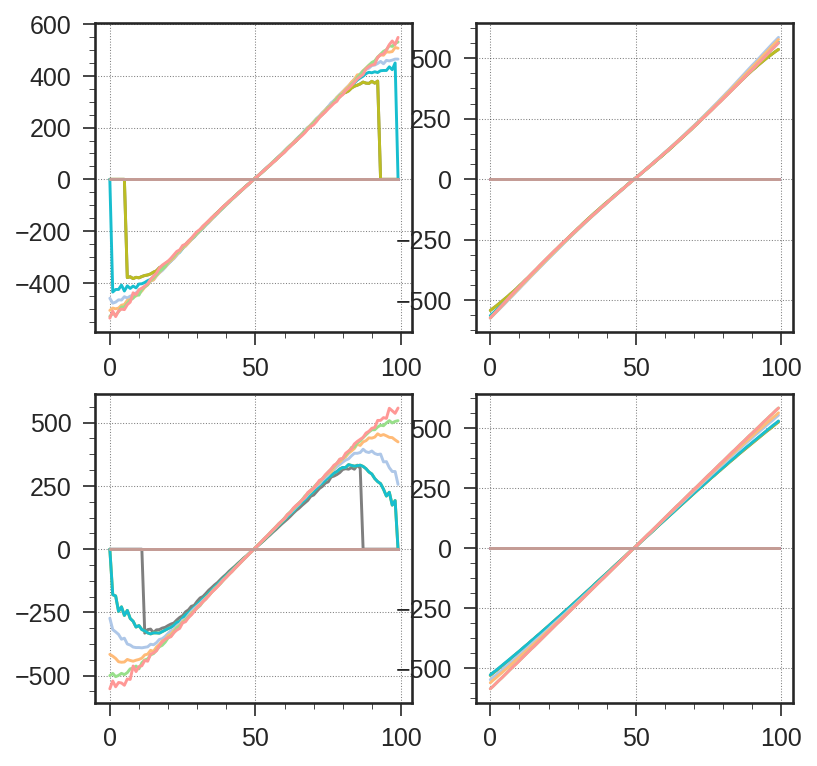

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(16):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [21]:
# ME1/2 w.r.t ME2, ME3

emtf_layer_me1 = 1

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(4,9):  # ME1/2, valid for eta <= 1.6
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 0.85+j*0.1
    eta_s = 0.85+(15)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 3
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 50
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 0.8+j*0.1, 0.8+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,8,emtf_layer_me1] = patterns_match_me2_2[:,7,emtf_layer_me1]
patterns_match_me3_2[:,8,emtf_layer_me1] = patterns_match_me3_2[:,7,emtf_layer_me1]

0,(1.2,1.3) 36 (589.9667456332002, 0.22733435431695534)
0,(1.3,1.4) 34 (2245.9541333214665, 0.35766714377758924)
0,(1.4,1.5) 32 (7540.834722507843, 0.5428855199389845)
0,(1.5,1.6) 30 (24076.10797870522, 0.8184822065429577)
0,(1.6,1.7) 28 (36825.09947378776, 1.0141138044768345)
1,(1.2,1.3) 36 (553.8825709917746, 0.18984065994892907)
1,(1.3,1.4) 34 (2203.411695983735, 0.30036695831710525)
1,(1.4,1.5) 32 (8072.534601482751, 0.4725736513120609)
1,(1.5,1.6) 30 (15954.084262908025, 0.5591947872753048)
1,(1.6,1.7) 28 (18094.43343420857, 0.5615641785209027)


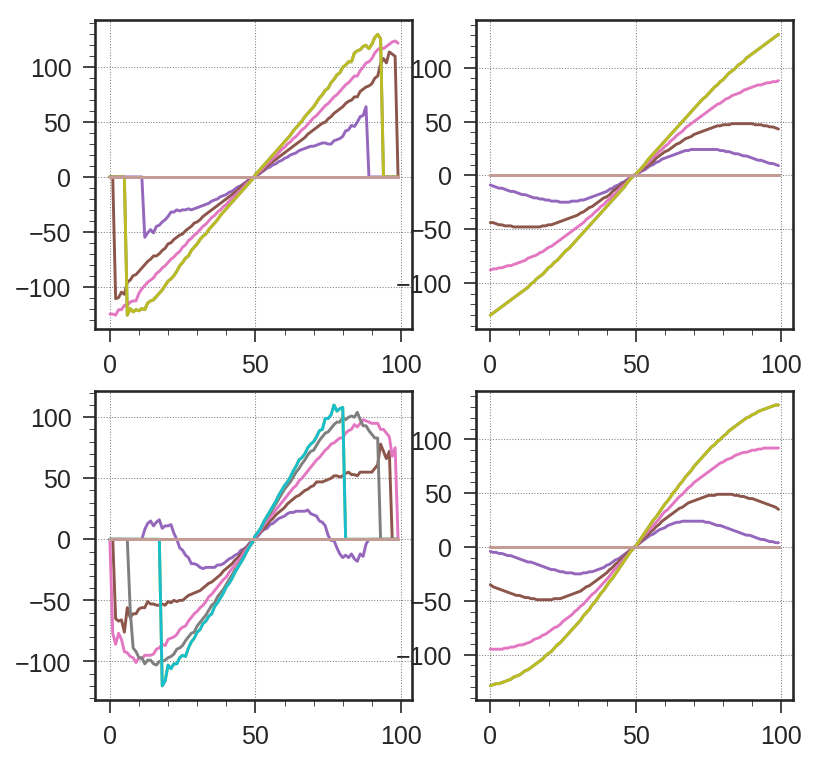

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(16):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

### Find pattern windows

In [23]:
%%time

np.random.seed(2023)

_get_emtf_layer = lambda x: x[0]

_get_emtf_phi = lambda x: x[1]

# More complicated pt binning
def find_pt_bin_complicated(ieta, pt):
  pt_bins_complicated = patterns_pt_binning_1[ieta]
  ipt = np.digitize((pt,), pt_bins_complicated[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins_complicated)-2)
  return ipt

patterns_phi = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)
patterns_match = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)
for ind in np.ndindex(patterns_phi.shape):
  patterns_phi[ind] = []
  patterns_match[ind] = []

# Loop over part and hits
# - part is (part_invpt, part_eta, part_phi, zone, endsec, mode)
# - hits is a collection of (emtf_layer, emtf_phi, old_emtf_phi)

print("Processing events ...")

for part, hits in zip(out_part, out_hits):
  (part_invpt, part_eta, part_phi, zone, endsec, mode) = part
  zone, endsec = int(round(zone)), int(round(endsec))
  hits = hits[hits[:,0] != -99]
  
  if np.abs(part_eta) < 1.24:
    continue
  
  ipt100 = find_pt_bin_100(part_invpt)
  ieta16 = find_eta_bin_16(part_eta)
  ipt = find_pt_bin(part_invpt)
  ieta = find_eta_bin(part_eta)
  
  # Use more complicated pt binning
  ipt = find_pt_bin_complicated(ieta, part_invpt)
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    amap.setdefault(_get_emtf_layer(hit), []).append(hit)
    
  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer
    
  # Find hit phi at the key station
  key_hit_phi = None
  
  def _get_dphi():
    dphi = np.float32(0)
    dphi += patterns_match_me2_2[ipt100, ieta16, emtf_layer_me1]
    dphi += patterns_match_me3_2[ipt100, ieta16, emtf_layer_me1]
    dphi *= 0.5
    dphi *= (np.sinh(1.8587) / np.sinh(np.abs(part_eta)))
    
    # Add some noise
    sigma = superstrip_size/np.sqrt(12)
    dphi += sigma * np.random.normal()
    dphi = np.round(dphi)
    return dphi.astype(np.int32)
  
  if key_hit_phi is None:
    emtf_layer_me1 = 11         # ME0
    if ieta16 in xrange(12,16): # ME0
      hit2 = amap.get(emtf_layer_me1, None)
      if hit2 is not None:
        key_hit_phi = _get_emtf_phi(hit2) - _get_dphi()
  
  if key_hit_phi is None:
    emtf_layer_me1 = 0         # ME1/1
    if ieta16 in xrange(7,16): # ME1/1
      hit2 = amap.get(emtf_layer_me1, None)
      if hit2 is not None:
        key_hit_phi = _get_emtf_phi(hit2) - _get_dphi()
        
  if key_hit_phi is None:
    emtf_layer_me1 = 9         # GE1/1
    if ieta16 in xrange(7,14): # GE1/1
      hit2 = amap.get(emtf_layer_me1, None)
      if hit2 is not None:
        key_hit_phi = _get_emtf_phi(hit2) - _get_dphi()
        
  if key_hit_phi is None:
    emtf_layer_me1 = 1        # ME1/2
    if ieta16 in xrange(4,9): # ME1/2
      hit2 = amap.get(emtf_layer_me1, None)
      if hit2 is not None:
        key_hit_phi = _get_emtf_phi(hit2) - _get_dphi()
        
  if key_hit_phi is None:
    continue
  
  # Make pair of hits
  for k, v in amap.iteritems():
    emtf_layer = k
    hit1 = v
    hit_phi1 = _get_emtf_phi(hit1)
    dphi = (hit_phi1 - key_hit_phi)
    patterns_phi[ipt, zone, emtf_layer].append(dphi)
    
    emtf_layer_partner = find_emtf_layer_partner(emtf_layer, zone)
    hit2 = amap.get(emtf_layer_partner, None)
    if hit2 is not None:
      hit_phi2 = _get_emtf_phi(hit2)
      dphi = (hit_phi1 - hit_phi2)
      patterns_match[ipt, zone, emtf_layer].append(dphi)
  continue  # end loop over part and hits

Processing events ...
CPU times: user 15min 22s, sys: 7.69 s, total: 15min 29s
Wall time: 15min 17s


In [24]:
# Histogram
# - make 47 bins, bin 23 is the highest pT
nbinsx = 47
firstbinx = 23
xlow = -0.5*nbinsx*superstrip_size
xup = +0.5*nbinsx*superstrip_size

please_symmetrize = True

valid_layers = np.zeros(patterns_phi.shape, dtype=np.bool)
valid_layers[:, 0, [0,2,3,4,7,8,10,11]]    = True
valid_layers[:, 1, [0,2,3,4,7,8,9,10,11]]  = True
valid_layers[:, 2, [0,2,3,4,7,8,9,10]]     = True
valid_layers[:, 3, [0,2,3,4,7,8,9,10]]     = True
valid_layers[:, 4, [0,1,2,3,4,7,8,9,10]]   = True
valid_layers[:, 5, [1,2,3,4,5,6,7,8]]      = True
valid_layers[:, 6, [1,2,3,5,6,7,12,13,14]] = True

patterns_phi_1 = np.zeros(patterns_phi.shape + (nbinsx,), dtype=np.int32)
patterns_phi_2 = np.zeros(patterns_phi.shape + (3,), dtype=np.int32)

for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    # Fix issues due to gap between ring 1 & ring 2 for ME2 at eta=1.6
    ipt, ieta, emtf_layer = ind
    x = patterns_phi[ind]
    if emtf_layer == 2:
      if ieta == 3:
        x = list(x) + patterns_phi[ipt, 4, emtf_layer]
      elif ieta == 4:
        x = list(x) + patterns_phi[ipt, 3, emtf_layer]
    # Fix issues due to gap between ring 1 & ring 2 for ME3 at eta=1.7
    elif emtf_layer == 3:
      #if ieta == 2:
      #  x = list(x) + patterns_phi[ipt, 3, emtf_layer]
      #elif ieta == 3:
      #  x = list(x) + patterns_phi[ipt, 2, emtf_layer]
      if ieta == 3:
        x = list(x) + patterns_phi[ipt, 4, emtf_layer]
      elif ieta == 4:
        x = list(x) + patterns_phi[ipt, 3, emtf_layer]
    # Fix issues due to gap between ring 1 & ring 2 for ME4 at eta=1.8
    elif emtf_layer == 4:
      if ieta == 3:
        x = list(x) + patterns_phi[ipt, 4, emtf_layer]
      elif ieta == 4:
        x = list(x) + patterns_phi[ipt, 3, emtf_layer]
    # Fix issues due to gap for RE3 (?)
    elif emtf_layer == 7:
      if ieta == 3:
        x = list(x) + patterns_phi[ipt, 4, emtf_layer]
      elif ieta == 4:
        x = list(x) + patterns_phi[ipt, 3, emtf_layer]
    # Fix issues due to gap for RE4 (?)
    elif emtf_layer == 8:
      if ieta == 3:
        x = list(x) + patterns_phi[ipt, 4, emtf_layer]
      elif ieta == 4:
        x = list(x) + patterns_phi[ipt, 3, emtf_layer]
    
    if not len(x):
      continue
    
    hist, _ = np.histogram(x, bins=nbinsx, range=(xlow,xup))
    patterns_phi_1[ind] = hist
    
    p = np.percentile(x, [2.5,50,97.5], overwrite_input=True)
    p = np.round(np.true_divide(p, superstrip_size))
    patterns_phi_2[ind] = p

if please_symmetrize:
  # Sum with its flipped and reversed self
  patterns_phi_1_flipped = np.flip(patterns_phi_1, axis=0)
  assert((patterns_phi_1[0] == patterns_phi_1_flipped[8]).all())
  assert((patterns_phi_1[1] == patterns_phi_1_flipped[7]).all())
  assert((patterns_phi_1[2] == patterns_phi_1_flipped[6]).all())
  assert((patterns_phi_1[3] == patterns_phi_1_flipped[5]).all())
  assert((patterns_phi_1[4] == patterns_phi_1_flipped[4]).all())
  patterns_phi_1 += patterns_phi_1_flipped[...,::-1]
  patterns_phi_1 /= 2

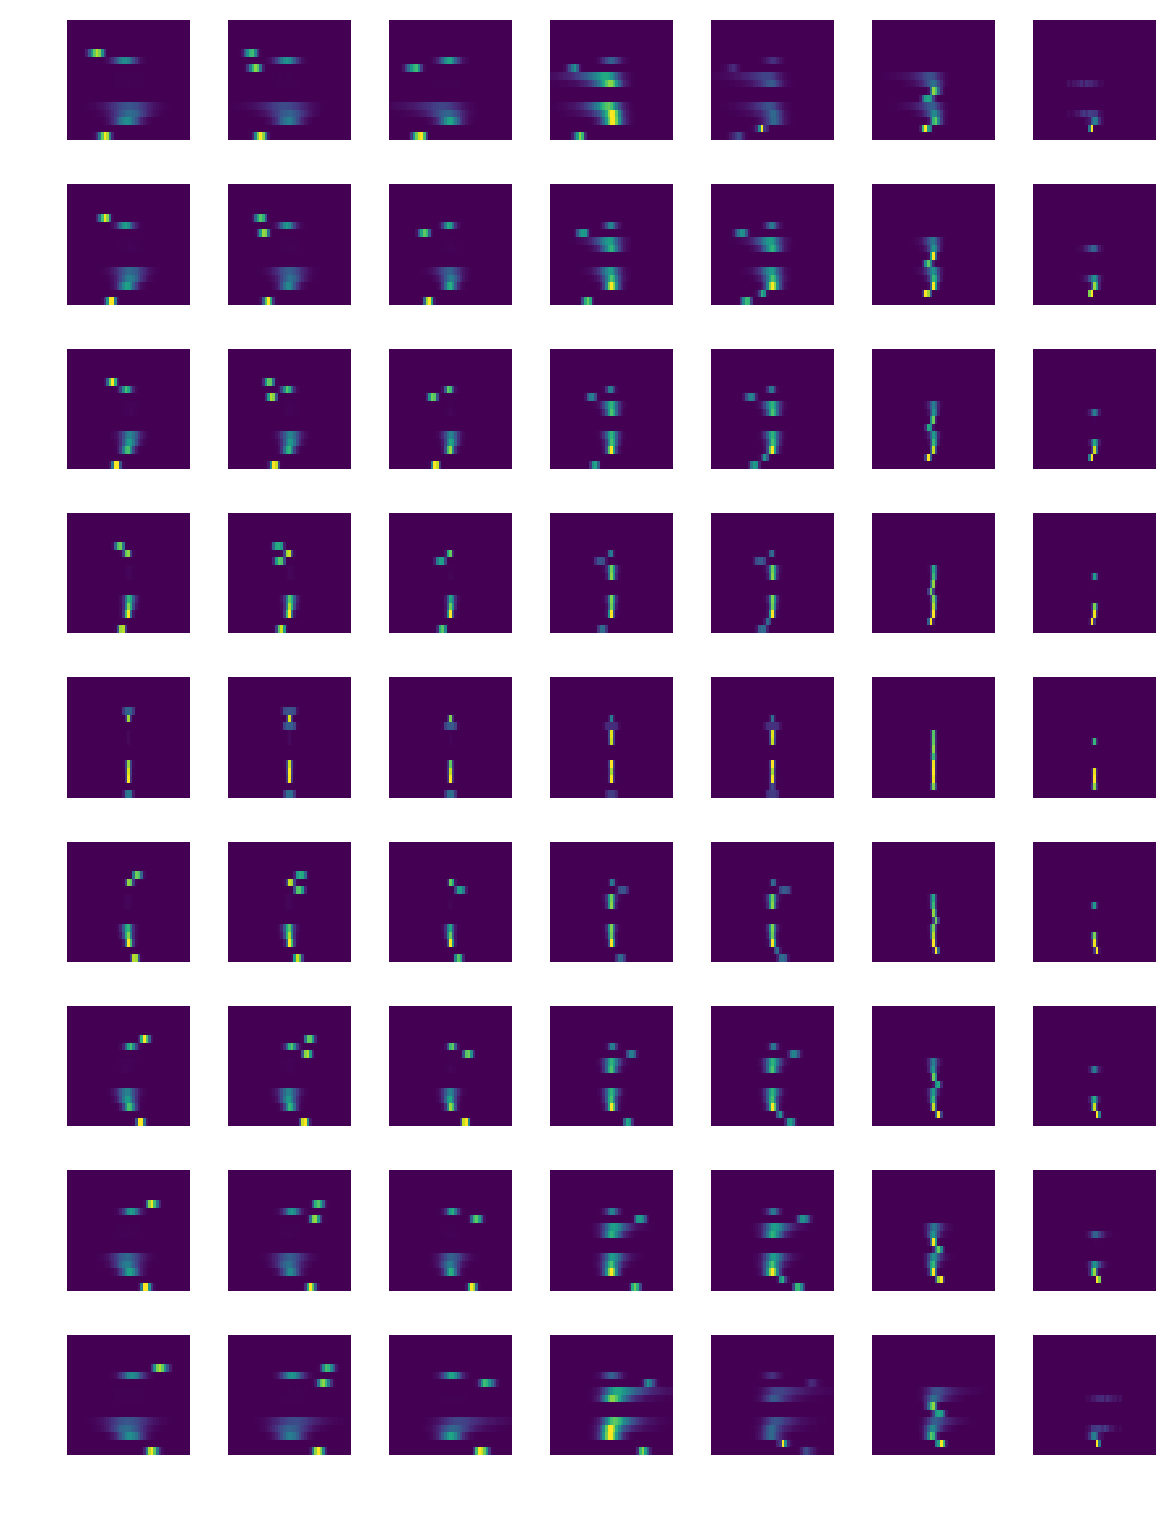

In [25]:
ncols = len(eta_bins)-1
nrows = len(pt_bins)-1

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8,8./ncols*nrows), tight_layout=True, sharex=True, sharey=True)

for i in xrange(nrows):
  for j in xrange(ncols):
    img = patterns_phi_1[i,j,:]
    axs[i,j].imshow(img, origin='lower', interpolation='nearest', aspect='auto')
    axs[i,j].axis('off')
    
plt.show()

In [26]:
# Find windows

#activation = 0.01
activation = 0.1
#activation = 0.12

for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    ipt, ieta, emtf_layer = ind
    
    if ieta == 6:
      continue
    
    x = patterns_phi_1[ind].copy().astype(np.float32)
    #norm = x.sum()
    norm = np.sqrt(np.square(x).sum())
    assert(np.isfinite(norm).all())
    x = np.true_divide(x, norm)
    x[np.isnan(x)] = 0
    
    act = activation
    if ieta in [6]:  # lower requirement in zones 3,4,5,6
      act -= 0.04
    elif ieta in [5]:
      act -= 0.04
    elif ieta in [2,3,4]:
      act -= 0.02
    
    #if ieta in [0,1,2,3,4] and emtf_layer in [5,6,7,8]:  # higher requirement on RPC
    #  act += 0.01
    
    try:
      y = np.where(x > act)[0] - firstbinx  # offset by firstbinx
      if (y[-1] - y[0]) != len(y)-1:
        print("[WARNING] The range is not continuous. Please check!")
      if y[-1] == y[0]:
        print("[WARNING] The range is zero. Please check!")
      y = y[0], y[-1]
    except:
      y = 0, 0
    
    print ind, y, patterns_phi_2[ind]
    patterns_phi_2[ind][0] = y[0]
    patterns_phi_2[ind][2] = y[1]
    
print np.min(patterns_phi_2), np.max(patterns_phi_2)

(0, 0, 0) (-11, -7) [-12  -9  -6]
(0, 0, 2) (-6, 4) [-7 -1  6]
(0, 0, 3) (-6, 7) [-8  0  9]
(0, 0, 4) (-8, 8) [-12   0  11]
(0, 0, 7) (-7, 8) [-10   0  10]
(0, 0, 8) (-8, 7) [-13   0  11]
(0, 0, 10) (-6, 3) [-7 -1  4]
(0, 0, 11) (-15, -10) [-16 -12  -9]
(0, 1, 0) (-13, -9) [-14 -11  -9]
(0, 1, 2) (-5, 4) [-7  0  6]
(0, 1, 3) (-7, 6) [-11   0   8]
(0, 1, 4) (-10, 6) [-17  -2   9]
(0, 1, 7) (-9, 6) [-13  -1   8]
(0, 1, 8) (-13, 6) [-18  -4  10]
(0, 1, 9) (-16, -11) [-16 -13 -11]
(0, 1, 10) (-5, 3) [-7 -1  4]
(0, 1, 11) (-17, -12) [-18 -15 -12]
(0, 2, 0) (-15, -9) [-15 -12  -9]
(0, 2, 2) (-5, 4) [-6  0  6]
(0, 2, 3) (-9, 5) [-14  -2   6]
(0, 2, 4) (-15, 4) [-24  -5   6]
(0, 2, 7) (-11, 4) [-19  -3   5]
(0, 2, 8) (-15, 4) [-28  -6   5]
(0, 2, 9) (-17, -11) [-17 -14 -11]
(0, 2, 10) (-4, 3) [-5  0  4]
(0, 3, 0) (-14, -10) [-15 -12 -10]
(0, 3, 2) (-4, 4) [-5  0  5]
(0, 3, 3) (-6, 4) [-12   0   5]
(0, 3, 4) (-10, 3) [-15  -2   4]
(0, 3, 7) (-8, 4) [-14  -1   5]
(0, 3, 8) (-14, 3) [-23  -4   4]

In [27]:
import contextlib

# Answer from https://stackoverflow.com/a/2891805
@contextlib.contextmanager
def np_printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally:
        np.set_printoptions(**original)

In [28]:
if True:
  # Check pT bin
  i = 3
  emtf_layer = 4
  
  x = patterns_phi_1[i,:,:].copy().astype(np.float32)
  #norm = x.sum(axis=-1, keepdims=True)
  norm = np.sqrt(np.square(x).sum(axis=-1, keepdims=True))
  assert(np.isfinite(norm).all())
  x = np.true_divide(x, norm)
  x[np.isnan(x)] = 0
  
  with np_printoptions(precision=3, suppress=True):
    for j in xrange(ncols):
      print x[j,emtf_layer], np.where(x[j,emtf_layer] > activation)[0] - firstbinx

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.007 0.03  0.12  0.366 0.653
 0.58  0.281 0.096 0.028 0.007 0.002 0.001 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-2 -1  0  1  2]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.002 0.009 0.037 0.131 0.384 0.67
 0.559 0.257 0.081 0.025 0.006 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-2 -1  0  1  2]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.003 0.015 0.083 0.349 0.742
 0.54  0.165 0.034 0.007 0.002 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-1  0  1  2]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0. 

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [29]:
if True:
  # Check zone
  zone = 3
  emtf_layer = 4
  
  x = patterns_phi_1[:,zone,:].copy().astype(np.float32)
  #norm = x.sum(axis=-1, keepdims=True)
  norm = np.sqrt(np.square(x).sum(axis=-1, keepdims=True))
  assert(np.isfinite(norm).all())
  x = np.true_divide(x, norm)
  x[np.isnan(x)] = 0
  
  with np_printoptions(precision=3, suppress=True):
    for i in xrange(nrows):
      print x[i,emtf_layer], np.where(x[i,emtf_layer] > activation-0.01)[0] - firstbinx

[0.003 0.004 0.005 0.007 0.01  0.012 0.015 0.022 0.025 0.031 0.042 0.052
 0.065 0.089 0.113 0.135 0.165 0.207 0.246 0.302 0.35  0.386 0.4   0.37
 0.299 0.214 0.131 0.075 0.039 0.022 0.01  0.005 0.002 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-9 -8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3]
[0.    0.    0.    0.    0.    0.    0.001 0.001 0.001 0.002 0.003 0.005
 0.007 0.011 0.019 0.031 0.052 0.083 0.135 0.205 0.293 0.387 0.467 0.484
 0.383 0.255 0.144 0.078 0.036 0.017 0.008 0.003 0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-5 -4 -3 -2 -1  0  1  2  3]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.001 0.003 0.007 0.017 0.048 0.125 0.277 0.48  0.593
 0.49  0.263 0.109 0.038 0.013 0.003 0.001 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-3 -2 -1  0  1  2  3]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [30]:
if True:
  # Check zone
  zone = 4
  emtf_layer = 4
  
  x = patterns_phi_1[:,zone,:].copy().astype(np.float32)
  #norm = x.sum(axis=-1, keepdims=True)
  norm = np.sqrt(np.square(x).sum(axis=-1, keepdims=True))
  assert(np.isfinite(norm).all())
  x = np.true_divide(x, norm)
  x[np.isnan(x)] = 0
  
  with np_printoptions(precision=3, suppress=True):
    for i in xrange(nrows):
      print x[i,emtf_layer], np.where(x[i,emtf_layer] > activation)[0] - firstbinx

[0.003 0.004 0.005 0.007 0.01  0.012 0.015 0.022 0.025 0.031 0.042 0.052
 0.065 0.089 0.113 0.135 0.165 0.207 0.246 0.302 0.35  0.386 0.4   0.37
 0.299 0.214 0.131 0.075 0.039 0.022 0.01  0.005 0.002 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-9 -8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3]
[0.    0.    0.    0.    0.    0.    0.001 0.001 0.001 0.002 0.003 0.005
 0.007 0.011 0.019 0.031 0.052 0.083 0.135 0.205 0.293 0.387 0.467 0.484
 0.383 0.255 0.144 0.078 0.036 0.017 0.008 0.003 0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-5 -4 -3 -2 -1  0  1  2  3]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.001 0.003 0.007 0.017 0.048 0.125 0.277 0.48  0.593
 0.49  0.263 0.109 0.038 0.013 0.003 0.001 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-3 -2 -1  0  1  2  3]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [31]:
if True:
  # Check zone
  zone = 5
  emtf_layer = 4
  
  x = patterns_phi_1[:,zone,:].copy().astype(np.float32)
  #norm = x.sum(axis=-1, keepdims=True)
  norm = np.sqrt(np.square(x).sum(axis=-1, keepdims=True))
  assert(np.isfinite(norm).all())
  x = np.true_divide(x, norm)
  x[np.isnan(x)] = 0
  
  with np_printoptions(precision=3, suppress=True):
    for i in xrange(nrows):
      print x[i,emtf_layer], np.where(x[i,emtf_layer] > activation)[0] - firstbinx

[0.    0.001 0.001 0.002 0.002 0.003 0.005 0.008 0.011 0.015 0.02  0.028
 0.037 0.048 0.058 0.081 0.107 0.137 0.191 0.244 0.329 0.404 0.452 0.442
 0.344 0.227 0.12  0.056 0.021 0.007 0.003 0.001 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-7 -6 -5 -4 -3 -2 -1  0  1  2  3]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001
 0.001 0.003 0.004 0.006 0.011 0.019 0.038 0.077 0.156 0.302 0.504 0.596
 0.461 0.221 0.069 0.016 0.003 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-3 -2 -1  0  1  2]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.006 0.024 0.113 0.406 0.74
 0.508 0.128 0.016 0.002 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-2 -1  0  1  2]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0. 

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [32]:
# Used for primitive matching

patterns_match_2 = np.zeros(patterns_match.shape + (3,), dtype=np.int32)

for ind in np.ndindex(patterns_match.shape):
  if valid_layers[ind]:
    # Fix issues due to gap between ring 1 & ring 2 for ME2 at eta=1.6
    ipt, ieta, emtf_layer = ind
    x = patterns_match[ind]
    if emtf_layer == 2:
      if ieta == 3:
        x = list(x) + patterns_match[ipt, 4, emtf_layer]
      elif ieta == 4:
        x = list(x) + patterns_match[ipt, 3, emtf_layer]
    # Fix issues due to gap between ring 1 & ring 2 for ME3 at eta=1.7
    elif emtf_layer == 3:
      #if ieta == 2:
      #  x = list(x) + patterns_match[ipt, 3, emtf_layer]
      #elif ieta == 3:
      #  x = list(x) + patterns_match[ipt, 2, emtf_layer]
      if ieta == 3:
        x = list(x) + patterns_match[ipt, 4, emtf_layer]
      elif ieta == 4:
        x = list(x) + patterns_match[ipt, 3, emtf_layer]
    # Fix issues due to gap between ring 1 & ring 2 for ME4 at eta=1.8
    elif emtf_layer == 4:
      if ieta == 3:
        x = list(x) + patterns_match[ipt, 4, emtf_layer]
      elif ieta == 4:
        x = list(x) + patterns_match[ipt, 3, emtf_layer]
    # Fix issues due to gap for RE3 (?)
    elif emtf_layer == 7:
      if ieta == 3:
        x = list(x) + patterns_match[ipt, 4, emtf_layer]
      elif ieta == 4:
        x = list(x) + patterns_match[ipt, 3, emtf_layer]
    # Fix issues due to gap for RE4 (?)
    elif emtf_layer == 8:
      if ieta == 3:
        x = list(x) + patterns_match[ipt, 4, emtf_layer]
      elif ieta == 4:
        x = list(x) + patterns_match[ipt, 3, emtf_layer]
    
    if not len(x):
      continue
    
    patterns_match_2[ind] = np.percentile(x, [5,50,95], overwrite_input=True)
    #print ind, patterns_match_2[ind]

### Postfix

In [33]:
# Increase ME1 windows in zone 0
ind = 3, 0, 0
old = patterns_phi_2[ind].copy()
new = [-4, -3, -1]
patterns_phi_2[ind] = new
print ind, old, '->', patterns_phi_2[ind]

ind = 4, 0, 0
old = patterns_phi_2[ind].copy()
new = [-2, 0, 2]
patterns_phi_2[ind] = new
print ind, old, '->', patterns_phi_2[ind]

ind = 5, 0, 0
old = patterns_phi_2[ind].copy()
new = [1, 3, 4]
patterns_phi_2[ind] = new
print ind, old, '->', patterns_phi_2[ind]

(3, 0, 0) [-4 -3 -1] -> [-4 -3 -1]
(4, 0, 0) [-2  0  2] -> [-2  0  2]
(5, 0, 0) [1 3 4] -> [1 3 4]


In [34]:
# Increase ME1 window in zone 4
ind = 1, 4, 1
old = patterns_phi_2[ind].copy()
new = [-5,-4,-2]
patterns_phi_2[ind] = new
print ind, old, '->', patterns_phi_2[ind]

ind = 7, 4, 1
old = patterns_phi_2[ind].copy()
new = [2,4,5]
patterns_phi_2[ind] = new
print ind, old, '->', patterns_phi_2[ind]

(1, 4, 1) [-5 -4 -3] -> [-5 -4 -2]
(7, 4, 1) [3 4 5] -> [2 4 5]


In [35]:
# Increase ME1 window in zone 5
ind = 0, 5, 1
old = patterns_phi_2[ind].copy()
new = [-5,-3,0]
patterns_phi_2[ind] = new
print ind, old, '->', patterns_phi_2[ind]

ind = 8, 5, 1
old = patterns_phi_2[ind].copy()
new = [0,3,5]
patterns_phi_2[ind] = new
print ind, old, '->', patterns_phi_2[ind]

(0, 5, 1) [-4 -3 -1] -> [-5 -3  0]
(8, 5, 1) [1 3 4] -> [0 3 5]


In [36]:
# Increase ME3,4 windows in zone 5
ind = 4, 5, 3
old = patterns_phi_2[ind].copy()
new = [-1, 0, 1]
patterns_phi_2[ind] = new
print ind, old, '->', patterns_phi_2[ind]

ind = 4, 5, 4
old = patterns_phi_2[ind].copy()
new = [-1, 0, 1]
patterns_phi_2[ind] = new
print ind, old, '->', patterns_phi_2[ind]

(4, 5, 3) [-1  0  1] -> [-1  0  1]
(4, 5, 4) [-1  0  1] -> [-1  0  1]


In [37]:
# Increase RE2 windows in zone 5
ind = 3, 5, 6
old = patterns_phi_2[ind].copy()
new = [-1, 0, 1]
patterns_phi_2[ind] = new
print ind, old, '->', patterns_phi_2[ind]

ind = 5, 5, 6
old = patterns_phi_2[ind].copy()
new = [-1, 0, 1]
patterns_phi_2[ind] = new
print ind, old, '->', patterns_phi_2[ind]

(3, 5, 6) [-1  0  0] -> [-1  0  1]
(5, 5, 6) [0 0 1] -> [-1  0  1]


### Save

In [38]:
outfile = 'pattern_bank.npz'
np.savez_compressed(outfile, patterns_phi=patterns_phi_2, patterns_match=patterns_match_2)

In [39]:
with np.load('pattern_bank.npz') as data:
  loaded_patterns_phi = data['patterns_phi']
  loaded_patterns_match = data['patterns_match']

In [40]:
print loaded_patterns_phi.shape
print loaded_patterns_phi[:,1,:5]

(9, 7, 16, 3)
[[[-13 -11  -9]
  [  0   0   0]
  [ -5   0   4]
  [ -7   0   6]
  [-10  -2   6]]

 [[-10  -8  -7]
  [  0   0   0]
  [ -4   0   3]
  [ -4   0   5]
  [ -6   0   6]]

 [[ -7  -6  -4]
  [  0   0   0]
  [ -3   0   2]
  [ -3   0   4]
  [ -3   0   4]]

 [[ -5  -3  -2]
  [  0   0   0]
  [ -2   0   1]
  [ -1   0   2]
  [ -2   0   2]]

 [[ -2   0   2]
  [  0   0   0]
  [ -1   0   1]
  [ -1   0   1]
  [ -1   0   1]]

 [[  2   3   5]
  [  0   0   0]
  [ -1   0   2]
  [ -2   0   1]
  [ -2   0   2]]

 [[  4   6   7]
  [  0   0   0]
  [ -2   0   3]
  [ -4   0   3]
  [ -4   0   3]]

 [[  7   8  10]
  [  0   0   0]
  [ -3   0   4]
  [ -5   0   4]
  [ -6   0   6]]

 [[  9  11  13]
  [  0   0   0]
  [ -4   0   5]
  [ -6   0   7]
  [ -6   2  10]]]


In [41]:
print loaded_patterns_match.shape
print loaded_patterns_match[:,1,:5]

(9, 7, 16, 3)
[[[-508 -333 -189]
  [   0    0    0]
  [ 189  333  508]
  [ 104  334  569]
  [ -53  271  563]]

 [[-368 -246 -145]
  [   0    0    0]
  [ 145  246  368]
  [ 123  270  433]
  [  67  254  450]]

 [[-257 -169 -100]
  [   0    0    0]
  [ 100  169  257]
  [  97  193  307]
  [  75  190  324]]

 [[-155  -90  -46]
  [   0    0    0]
  [  46   90  155]
  [  50  105  187]
  [  44  107  198]]

 [[ -55    0   56]
  [   0    0    0]
  [ -56    0   55]
  [ -66   -1   65]
  [ -70   -1   68]]

 [[  47   91  155]
  [   0    0    0]
  [-155  -91  -47]
  [-187 -106  -51]
  [-198 -108  -45]]

 [[  99  169  257]
  [   0    0    0]
  [-257 -169  -99]
  [-308 -193  -97]
  [-324 -191  -74]]

 [[ 146  247  369]
  [   0    0    0]
  [-369 -247 -146]
  [-434 -271 -124]
  [-449 -255  -68]]

 [[ 188  334  509]
  [   0    0    0]
  [-509 -334 -188]
  [-571 -337 -105]
  [-561 -275   55]]]
